<a href="https://colab.research.google.com/github/veyselberk88/Data-Science-Tools-and-Ecosystem/blob/main/lec38.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="./ccsf.png" alt="CCSF Logo" width=200px style="margin:0px -5px">

# Lecture 38: Evaluating Classifiers

Associated Textbook Sections: [17.5](https://ccsf-math-108.github.io/textbook/chapters/17/5/Accuracy_of_the_Classifier.html)

---

## Outline

* [Nearest Neighbors Classifier](#Nearest-Neighbors-Classifier)
* [Evaluation](#Evaluation)
* [Before Classifying](#Before-Classifying)
* [Example: The Google Science Fair](#Example:-The-Google-Science-Fair)
* [Picking `k`](#Picking-k)

---

## Set Up the Notebook

In [ ]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

---

## Nearest Neighbors Classifier

---

### Rebuild the Classifier

Here are the functions from the last lecture:

In [ ]:
def distance(pt1, pt2):
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

def row_distance(row1, row2):
    """Return the distance between two numerical rows of a table"""
    return distance(np.array(row1), np.array(row2))

def distances(training, example):
    """
    Compute distance between example row and every row in training.
    Return training augmented with Distance column
    """
    distances = make_array()
    features_only = training.drop('Class')

    for row in features_only.rows:
        distances = np.append(distances, row_distance(row, example))

    return training.with_column('Distance_to_ex', distances)

def closest(training, example, k):
    """
    Return a table of the k closest neighbors to example
    """
    return distances(training, example).sort('Distance_to_ex').take(np.arange(k))

def majority_class(topk):
    """
    Return the class with the highest count
    """
    return topk.group('Class').sort('count', descending=True).column(0).item(0)

def classify(training, example, k):
    """
    Return the majority class among the
    k nearest neighbors of example
    """
    return majority_class(closest(training, example, k))

---

## Evaluation

---

### Accuracy of a Classifier

* The accuracy of a classifier on a labeled data set is the proportion of examples in the test set that are labeled correctly
* Need to compare classifier predictions to true labels
* If the labeled data set is sampled at random from a population, then we can infer accuracy on that population

---

### Demo: Accuracy of a Classifier

* Reload the `ckd` data from the previous 2 lectures already split into two tables, where approximately 80% of the data is used for training and 20% is used for testing.
* Create a function that evaluates the accuracy by returning the proportion of correctly classified examples in the test set.
* Evaluate the accuracy for `k = 5`.
* Re-evaluate the accuracy if the White Blood Cell Count feature is included.

In [ ]:
ckd = (Table.read_table('ckd.csv')
       .relabeled('Blood Glucose Random', 'Glucose')
       .select('Glucose', 'Hemoglobin', 'Class'))
ckd

Glucose,Hemoglobin,Class
117,11.2,1
70,9.5,1
380,10.8,1
157,5.6,1
173,7.7,1
95,9.8,1
264,12.5,1
70,10,1
253,10.5,1
163,9.8,1


In [ ]:
np.random.seed(123) # Makes sure we all get the same data
row_80th = round(ckd.num_rows * 0.80)
train, test = ckd.split(row_80th)

In [ ]:
train

Glucose,Hemoglobin,Class
122,12.6,1
273,8.3,1
95,15,0
104,17.3,0
74,15.1,0
132,13.7,0
131,15.6,0
113,16.5,0
75,16.5,0
131,15.8,0


In [ ]:
test

Glucose,Hemoglobin,Class
105,15.7,0
89,15,0
130,13.5,0
100,14.3,0
93,16.7,0
111,16.3,0
100,15.8,0
214,9.4,1
137,13.6,0
380,10.8,1


In [ ]:
predicted_classes = make_array()
test_attributes = test.drop('Class')
for i in np.arange(test.num_rows):
    predicted_class = classify(train, test_attributes.row(i), 5)
    predicted_classes = np.append(predicted_classes, predicted_class)

predicted_classes

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.])

In [ ]:
test_with_predictions = test.with_column('Predicted Class', predicted_classes)
test_with_predictions

Glucose,Hemoglobin,Class,Predicted Class
105,15.7,0,0
89,15,0,0
130,13.5,0,0
100,14.3,0,0
93,16.7,0,0
111,16.3,0,0
100,15.8,0,0
214,9.4,1,1
137,13.6,0,0
380,10.8,1,1


In [ ]:
np.average(test_with_predictions.column('Class') == predicted_classes)

1.0

In [ ]:
def evaluate_accuracy(training, test, k):
    '''Return the proportion of correctly classified examples
    in the test set'''
    test_attributes = test.drop('Class')
    predicted_classes = make_array()
    for i in np.arange(test.num_rows):
        predicted_class = classify(train, test_attributes.row(i), k)
        predicted_classes = np.append(predicted_classes, predicted_class)

    test_with_predictions = test.with_column('Predicted Class', predicted_classes)
    accuracy = np.average(test_with_predictions.column('Class') == predicted_classes)
    return accuracy

In [ ]:
evaluate_accuracy(train, test, 5)

1.0

In [ ]:
# Add White Blood Cell Count
ckd = (Table.read_table('ckd.csv')
       .relabeled('Blood Glucose Random', 'Glucose')
       .select('Glucose', 'Hemoglobin',
               'White Blood Cell Count', 'Class'))
ckd

Glucose,Hemoglobin,White Blood Cell Count,Class
117,11.2,6700,1
70,9.5,12100,1
380,10.8,4500,1
157,5.6,11000,1
173,7.7,9200,1
95,9.8,6900,1
264,12.5,9600,1
70,10,18900,1
253,10.5,7200,1
163,9.8,14600,1


In [ ]:
# Same Train/Test Split with White Blood Cell Count added
np.random.seed(123) # Makes sure we all get the same data
row_80th = round(ckd.num_rows * 0.80)
train, test = ckd.split(row_80th)

In [ ]:
train

Glucose,Hemoglobin,White Blood Cell Count,Class
122,12.6,7900,1
273,8.3,14600,1
95,15,6300,0
104,17.3,8200,0
74,15.1,9700,0
132,13.7,7500,0
131,15.6,9400,0
113,16.5,8000,0
75,16.5,7800,0
131,15.8,6800,0


In [ ]:
test

Glucose,Hemoglobin,White Blood Cell Count,Class
105,15.7,10400,0
89,15,10300,0
130,13.5,6700,0
100,14.3,6700,0
93,16.7,6200,0
111,16.3,8000,0
100,15.8,6600,0
214,9.4,11500,1
137,13.6,7900,0
380,10.8,4500,1


In [ ]:
evaluate_accuracy(train, test, 5)

0.9375

---

### Data Leakage

- In the last demo, we **used the same test set twice** (just ignoring the `'White Blood Cell Count'` feature initially
- This is generally a **bad practice** and should be avoided
- We did it here to show the impact of the feature selection

---

## Before Classifying

---

### Start with a Representative Sample

<img src="./dog_wolf.png" width=60%>

* Both the training and test sets must accurately represent the population on which you use your classifier
* Overfitting happens when a classifier does very well on the training set, but can't do as well on the test set

---

### Standardize Data

In [ ]:
ckd.show(4)

Glucose,Hemoglobin,White Blood Cell Count,Class
117,11.2,6700,1
70,9.5,12100,1
380,10.8,4500,1
157,5.6,11000,1


- If the attributes are on very different numerical scales, **distances can be distorted**.
- As a result, classification can be **biased toward features with larger numerical values**.
    - For example, in the `ckd` data, **Glucose** and **White Blood Cell Count** values are generally **orders of magnitude larger** than **Hemoglobin** values.
    - This means our classification in the previous lecture was **more influenced by Glucose and White Blood Cell Count** than by Hemoglobin.
    - In situations like this, it's a good idea to **convert all variables to standard units**.
- **Standardizing** puts all numerical values on the **same scale**, making distance comparisons fair.
- The best practice is to standardize the training and test set after splitting using the mean and standard deviation from the training set.

---

### Demo: Standardizing Data

Explore what can happen to the classifier's accuracy (with 3 features) when the units are not standardized.

In [ ]:
train, test = ckd.split(row_80th)

In [ ]:
train.show(4)

Glucose,Hemoglobin,White Blood Cell Count,Class
133,10.3,6200,1
83,17.5,9900,0
130,13.4,7300,0
139,14.8,5600,0


In [ ]:
test.show(4)

Glucose,Hemoglobin,White Blood Cell Count,Class
125,17.4,6700,0
132,13.7,7500,0
117,16.2,8600,0
81,13.9,6900,0


In [ ]:
accuracy_og_units = evaluate_accuracy(train, test, 5)
accuracy_og_units

0.90625

In [ ]:
def standardize_from_training(train, test):
    """Standardize all columns (except 'Class') in train and test tables,
    using training set stats. Returns (train_su, test_su)."""

    new_train_cols = []
    new_test_cols = []

    for label in train.labels:
        if label == "Class":
            # Leave 'Class' column unchanged
            new_train_cols.append(train.column(label))
            new_test_cols.append(test.column(label))
        else:
            train_values = train.column(label)
            mean_train = np.average(train_values)
            SD_train = np.std(train_values)

            # Standardize using training mean and SD
            new_train_cols.append((train_values - mean_train) / SD_train)
            new_test_cols.append((test.column(label) - mean_train) / SD_train)

    train_su = Table().with_columns(zip(train.labels, new_train_cols))
    test_su = Table().with_columns(zip(test.labels, new_test_cols))

    return train_su, test_su

In [ ]:
train_su, test_su = standardize_from_training(train, test)

In [ ]:
train_su.show(4)

Glucose,Hemoglobin,White Blood Cell Count,Class
-0.0202733,-1.15757,-0.684666,1
-0.767185,1.32858,0.44282,0
-0.065088,-0.0871467,-0.349467,0
0.0693561,0.396271,-0.867501,0


In [ ]:
test_su.show(4)

Glucose,Hemoglobin,White Blood Cell Count,Class
-0.139779,1.29405,-0.532303,0
-0.0352115,0.0164428,-0.288522,0
-0.259285,0.879688,0.0466762,0
-0.797061,0.0855024,-0.471358,0


In [ ]:
accuracy_su = evaluate_accuracy(train_su, test_su, 5)
accuracy_su

0.78125

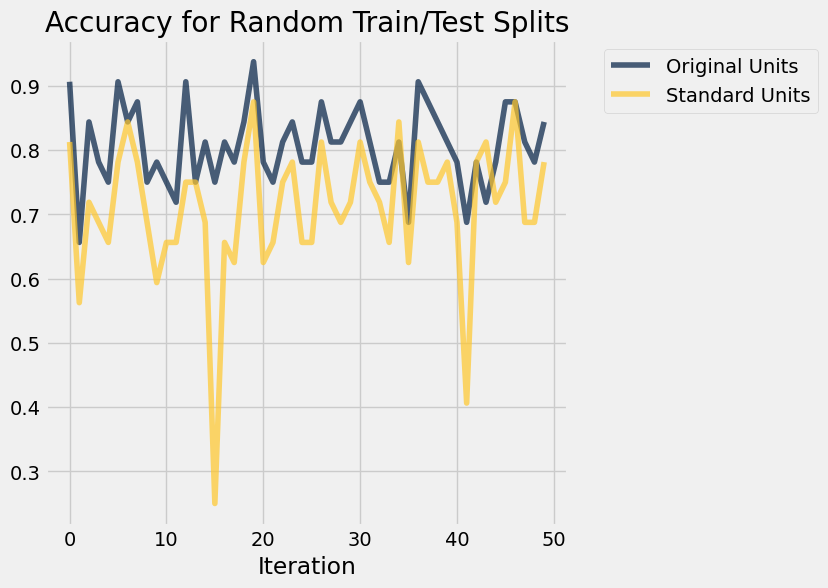

In [ ]:
accuracies_ou = make_array()
accuracies_su = make_array()
num_iter = 50
for _ in np.arange(num_iter):
    train, test = ckd.split(row_80th)
    train_su, test_su = standardize_from_training(train, test)
    accuracies_ou = np.append(accuracies_ou, evaluate_accuracy(train, test, 5))
    accuracies_su = np.append(accuracies_su, evaluate_accuracy(train_su, test_su, 5))

accuracies = Table().with_columns(
    'Iteration', np.arange(num_iter),
    'Original Units', accuracies_ou,
    'Standard Units', accuracies_su
)
accuracies.plot('Iteration')
plt.title('Accuracy for Random Train/Test Splits')
plt.show()

---

## Example: The Google Science Fair

<img src="./google_fair.png" width=60%>

[Brittany Wenger](https://edu.google.com/case-studies/brittany-wenger/), a 17-year-old high school student in 2012 won by building a breast cancer classifier with 99% accuracy.


---

### Demo: Google Science Fair

- Load the `breast-cancer.csv` dataset, which contains cell measurements and a label: **benign (0)** or **malignant (1)**.  
- The values were assigned manually by medical professionals after visually inspecting images.
- Visualize the relationship between **Bland Chromatin** and **Single Epithelial Cell Size** to try to classify the cells.
    - The scatter plot may look like it has only a few points because many data points overlap.
    - This happens because the measurements are not precise numbers but more like categories or rankings, leading to **many repeated values**.
    - The `jittered` table adds random noise to the points to make them easier to see and avoid **overplotting**.  
    - [What is overplotting?](https://blogs.sas.com/content/iml/2011/07/05/jittering-to-prevent-overplotting-in-statistical-graphics.html#:~:text=Jittering%20is%20the%20act%20of,rounded%20to%20some%20convenient%20unit.)
- Split `patients` data into a training set and a test set.
- Classify an example patient using 5-NN and check the accuracy.

In [ ]:
patients = (Table.read_table('breast-cancer.csv')
                 .drop('ID'))
patients.show(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


In [ ]:
patients.group('Class')

Class,count
0,444
1,239


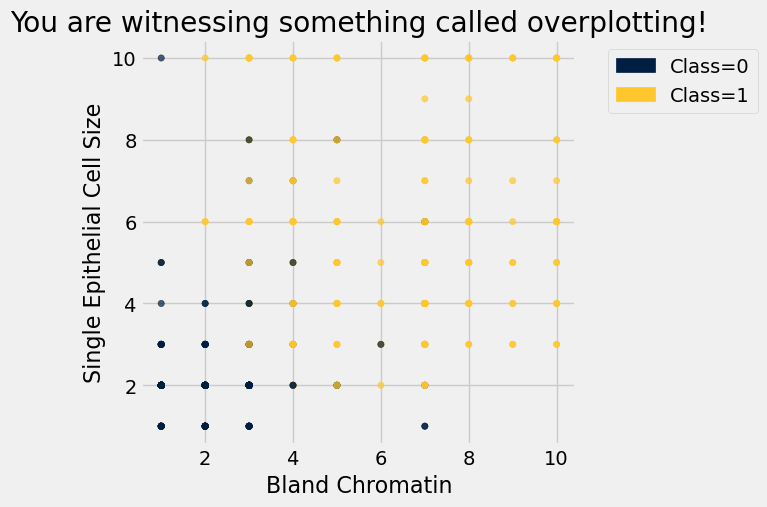

In [ ]:
patients.scatter('Bland Chromatin',
                 'Single Epithelial Cell Size',
                 group='Class')
plt.title('You are witnessing something called overplotting!')
plt.show()

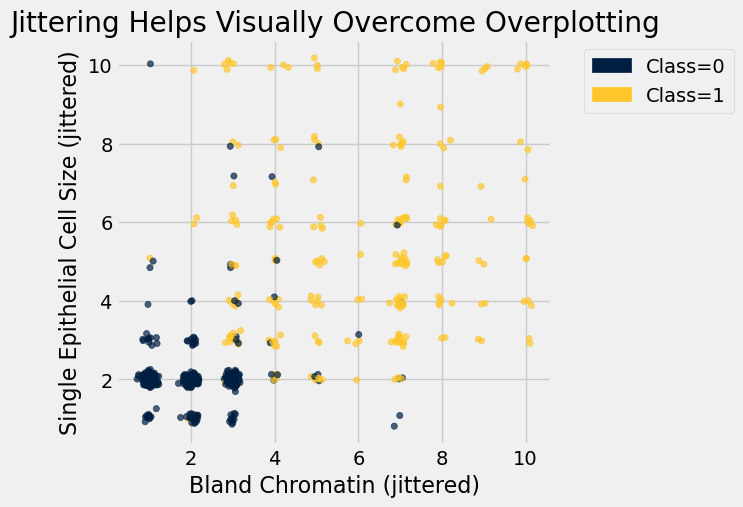

In [ ]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)',
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)',
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

jittered.scatter(0, 1, group='Class')
plt.title('Jittering Helps Visually Overcome Overplotting')
plt.show()

In [ ]:
row_80th_percentile = round(patients.num_rows * 0.80)
train_bc, test_bc = patients.split(row_80th_percentile)

In [ ]:
example_patient = test_bc.drop('Class').row(2)
example_patient

Row(Clump Thickness=1, Uniformity of Cell Size=1, Uniformity of Cell Shape=1, Marginal Adhesion=1, Single Epithelial Cell Size=2, Bare Nuclei=1, Bland Chromatin=1, Normal Nucleoli=1, Mitoses=1)

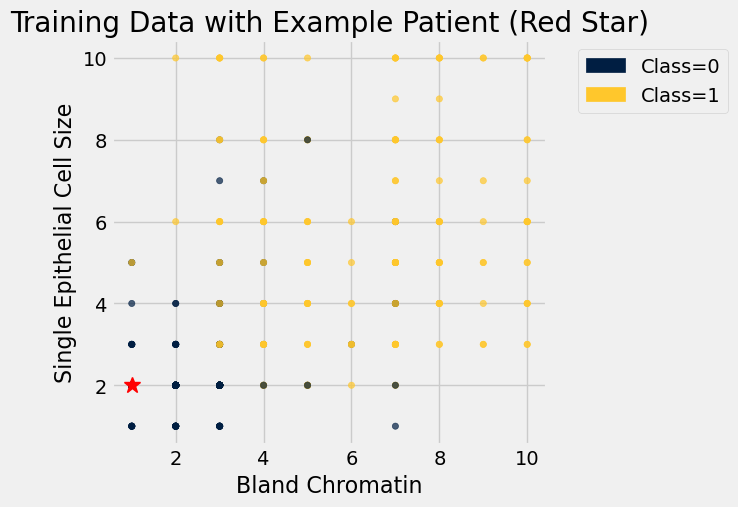

In [ ]:
train_bc.scatter('Bland Chromatin',
                 'Single Epithelial Cell Size',
                 group='Class')
plt.plot(example_patient.item('Bland Chromatin'),
         example_patient.item('Single Epithelial Cell Size'),
         marker='*', color='red', markersize=12)
plt.title('Training Data with Example Patient (Red Star)')
plt.show()

In [ ]:
classify(train_bc, example_patient, 5)

0

In [ ]:
actual_label = test_bc.row(2).item('Class')
actual_label

0

In [ ]:
train_bc.show(4)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
10,8,4,4,4,10,3,10,4,1
3,1,1,1,2,1,2,3,1,0
5,10,10,6,10,10,10,6,5,1
3,2,2,1,4,3,2,1,1,0


In [ ]:
test_bc.show(4)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
2,1,1,1,2,1,2,1,1,0
4,3,3,1,2,1,3,3,1,0
1,1,1,1,2,1,1,1,1,0
1,2,3,1,2,1,2,1,1,0


In [ ]:
evaluate_accuracy(train_bc, test_bc, 5)

ValueError: operands could not be broadcast together with shapes (3,) (9,) 

---

## Picking `k`

- How can we decide on which value of `k` to use?
    - Evaluate a performance metric for various values of `k`
    - Determine the optimal `k` that is found by finding the smallest `k` with the best performance
- Do you use the test set for this?
    - No! The test should only be used once.
    - Instead, when deciding on a good value for `k`
        - Split the training set further into 2 sets, training and validation
        - Use the validation set to assess the "accuracy" for different values of `k`

---

### Demo: Picking `k`

- Re-split the training set into training and validation sets.
- Calculate the accuracy on the validation set for several values of `k`.
- Visualize the trend in accuracy over the `k` to find the optimal value.

In [ ]:
row_70th_percentile = round(train_bc.num_rows*(0.70))
new_train, validation = train_bc.split(row_70th_percentile )

In [ ]:
new_train.show(4)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
1,1,1,1,2,1,2,1,1,0
1,1,1,1,2,1,3,1,1,0
5,8,8,10,5,10,8,10,3,1
5,2,3,1,6,10,5,1,1,1


In [ ]:
validation.show(4)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,2,2,4,2,4,1,1,1,0
5,5,7,8,6,10,7,4,1,1
5,1,3,1,2,1,2,1,1,0
2,1,1,1,1,1,1,1,1,0


In [ ]:
def knn(training, testing, k):
    """Returns the test predictions in the test set in a table, along with their actual classifications"""

    predictions = make_array()
    for i in np.arange(testing.num_rows):
        predictions = np.append(predictions, classify(training,
                                                     testing.drop('Class').row(i),
                                                     k))

    knn_table = Table().with_columns('Actual', testing.column('Class'),
                                     'Predicted', predictions)

    return knn_table

In [ ]:
def which_k(training, validation, k_values):

    accuracies = make_array()

    for i in np.arange(np.size(k_values)):

        evaluate_accuracy(training, validation, k_values.item(i))
        accuracies = np.append(accuracies,
                               evaluate_accuracy(training, validation, k_values.item(i)))

    k_table = Table().with_columns("k", k_values,
                                   "Accuracy", accuracies)

    return k_table

In [ ]:
k_s = make_array(1,3,5,7,9,11,13,15,17,19,21,23,25) # Try many odd k values
k_table = which_k(new_train, validation, k_s)
k_table

ValueError: operands could not be broadcast together with shapes (3,) (9,) 

In [ ]:
k_table.plot('k', 'Accuracy')
plt.title('The best k for the job is...?');

---

## Attribution

This content is licensed under the <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC BY-NC-SA 4.0)</a> and derived from the <a href="https://www.data8.org/">Data 8: The Foundations of Data Science</a> offered by the University of California, Berkeley.

<img src="./by-nc-sa.png" width=100px>